# Set up environments

In [32]:
!pip install -q beautifulsoup4==4.12.2 PyMuPDFb==1.24.10 PyMuPDF==1.24.13 tqdm==4.66.5 duckdb==0.10.0 tabulate==0.9.0 plotly==5.20.0 python-dotenv openai==1.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [2]:
import os

if not ".git" in os.listdir():
    !git clone https://github.com/batprem/pyo3-experiment
    os.chdir("pyo3-experiment")

Cloning into 'pyo3-experiment'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 29 (delta 5), reused 29 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 15.88 KiB | 5.29 MiB/s, done.
Resolving deltas: 100% (5/5), done.


# Download 56-1 file

In [3]:
import requests
from bs4 import BeautifulSoup
import os
import zipfile
from tqdm import tqdm


ROOT = "downloaded-56-1"
SYMBOL = "PTT"  # Change this symbol
# SYMBOL = "KBANK"  # Change this symbol
FILE_PATH = f"{ROOT}/{SYMBOL}"
PATH_TO_TARGET = f"{FILE_PATH}/{SYMBOL}.zip"
session = requests.Session()



os.makedirs(FILE_PATH, exist_ok=True)
print("Searching the balance sheet file")

response = session.get(
    f"https://market.sec.or.th/public/idisc/th/Viewmore/fs-r561?searchSymbol={SYMBOL}",
)
soup = BeautifulSoup(response.text)
url = soup.find_all("tr")[1].find_all("td")[-1].find("a")["href"]

print(f"Found at {url}")
# Sizes in bytes.
total_size = int(response.headers.get("content-length", 0))
block_size = 1024
response = session.get(url, stream=True)

print("Downloading...")
with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(PATH_TO_TARGET, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)


# with open(PATH_TO_TARGET, "wb") as f:
#     f.write(requests.get(url).content)

with zipfile.ZipFile(PATH_TO_TARGET, 'r') as zip_ref:
    zip_ref.extractall(FILE_PATH)
print("Done")

Searching the balance sheet file
Found at https://market.sec.or.th/public/idisc/Download?FILEID=dat/f56/0646ONE140320241323370901T.zip
Downloading...


44.0MB [01:10, 627kB/s]


Done


# Extract table of contents

In [6]:
import fitz
import pandas as pd

def to_html(filepath: str):
    doc = fitz.open(filepath)
    for i, page in enumerate(doc):
        text = page.get_text("html")
        with open(f"pymupdf-page-{i}.html", "w") as fp:
            fp.write(text)
    doc.close()

doc = fitz.open(f'{FILE_PATH}/STRUCTURE{SYMBOL}T.PDF')
toc = pd.DataFrame(doc.get_toc())
toc.columns = ["hierachy", "topic", "page"]
toc = toc[toc["topic"] != "Bookmark"].reset_index(drop=True)
toc

,hierachy,topic,page
0,1,Cover,1
1,1,TableContent,2
2,1,StructureAndOperation,4
3,1,RiskManagement,9
4,1,ESG,13
5,1,CorporateGovernancePolicy,18
6,1,CorporateGovernanceStructure,20
7,1,ResultOfCorporateGovernance,32


from matplotlib import pyplot as plt
toc['page'].plot(kind='hist', bins=20, title='page')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
toc.groupby('topic').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['hierachy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'hierachy'}, axis=1)
              .sort_values('hierachy', ascending=True))
  xs = counted['hierachy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = toc.sort_values('hierachy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('topic')):
  _plot_series(series, series_name, i)
  fig.legend(title='topic', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('hierachy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['page']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'page'}, axis=1)
              .sort_values('page', ascending=True))
  xs = counted['page']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = toc.sort_values('page', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('topic')):
  _plot_series(series, series_name, i)
  fig.legend(title='topic', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('page')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
toc['page'].plot(kind='line', figsize=(8, 4), title='page')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(toc['topic'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(toc, x='page', y='topic', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
bussiness_type = doc[3].get_text().split("ประเภทธุรกิจ\n:")[1].strip().split("\nเลขทะเบียนบริษัท")[0]
print(bussiness_type)

ประกอบด้วยกิจการที่ ปตท. ดำเนินการเอง ได้แก่ ธุรกิจก๊าซธรรมชาติ ธุรกิจ
ระบบท่อส่งก๊าซธรรมชาติ ธุรกิจการค้าระหว่างประเทศ
ธุรกิจใหม่และโครงสร้างพื้นฐาน และธุรกิจที่ลงทุนผ่านบริษัทย่อยและ/หรือ
กิจการที่ควบคุมร่วมกันและบริษัทร่วม (กลุ่มบริษัท) ได้แก่ ธุรกิจสำรวจและผลิต
ปิโตรเลียม ธุรกิจก๊าซธรรมชาติเหลว ธุรกิจปิโตรเคมีและการกลั่น ธุรกิจน้ำมัน
และค้าปลีก ธุรกิจไฟฟ้าและสาธารณูปการ ธุรกิจให้บริการ


In [8]:
first_page_index = toc.index[toc["topic"] == "StructureAndOperation"][0]
end_page_index = first_page_index + 1
first_page, end_page = toc.loc[[first_page_index, end_page_index]]["page"].to_list()

In [40]:
from IPython.display import display
import duckdb

structure_type = "Not defined"

def get_sql_create_a_table_from_dataframe(df: pd.DataFrame, name: str) -> str:
    duckdb.sql(f"CREATE TABLE OR REPLACE '{name}' AS SELECT * FROM df")

    # insert into the table "my_table" from the DataFrame "my_df"
    duckdb.sql(f"INSERT INTO '{name}' SELECT * FROM df")


for page in range(first_page, end_page):
    for table in doc[page].find_tables():
        df = table.to_pandas()
        if "Col1" in df.columns:
            columns_list = df.columns.to_list()
            columns_list[1:] = df.iloc[0].to_list()[1:]
            structure_type = columns_list[0]
            columns_list[0] = "detail"
            df.columns = columns_list
            df = df.iloc[1:]

        if "Col0" in df.columns:
            df.columns = columns_list
        get_sql_create_a_table_from_dataframe(df, structure_type)
        # display(df)

In [10]:
tables = duckdb.sql("SHOW TABLES")

In [25]:
table = "โครงสร้างรายได้จากในประเทศและจากต่างประเทศ"
income_domestic_foriegn = duckdb.sql(f"SELECT * FROM '{table}'").to_df().drop_duplicates().to_markdown(index=False)
print(income_domestic_foriegn)

| detail                         | 2564             | 2565             | 2566             |
|:-------------------------------|:-----------------|:-----------------|:-----------------|
| รายได้จากการดำเนินงานรวม (พันบาท) | 2,258,818,487.07 | 3,367,202,701.45 | 3,144,550,828.53 |
| รายได้จากในประเทศ (พันบาท)       | 1,329,573,212.58 | 1,933,531,559.66 | 1,744,025,735.77 |
| รายได้จากต่างประเทศ (พันบาท)      | 929,245,274.49   | 1,433,671,141.79 | 1,400,525,092.76 |
| รายได้จากการดำเนินงานรวม (%)     | 100.00           | 100.00           | 100.00           |
| รายได้จากในประเทศ (%)           | 58.86            | 57.42            | 55.46            |
| รายได้จากต่างประเทศ (%)          | 41.14            | 42.58            | 44.54            |


In [26]:
revenue_by_business_group = duckdb.sql("SELECT * FROM 'โครงสร้างรายได้ของสายผลิตภัณฑ์หรือกลุ่มธุรกิจ'").to_df().drop_duplicates().to_markdown(index=False)
print(revenue_by_business_group)

| detail                          | 2564             | 2565             | 2566             |
|:--------------------------------|:-----------------|:-----------------|:-----------------|
| รายได้จากการดำเนินงานรวม (พันบาท)  | 2,258,818,487.07 | 3,367,202,701.45 | 3,144,550,828.53 |
| สำรวจและผลิตปิโตรเลียม (พันบาท)     | 63,564,280.16    | 83,469,331.58    | 76,240,254.24    |
| ก๊าซธรรมชาติ (พันบาท)              | 317,521,958.80   | 509,391,306.43   | 471,875,240.24   |
| น้ำมัน (พันบาท)                    | 503,914,383.50   | 776,455,993.90   | 736,805,268.46   |
| ปิโตรเคมีและการกลั่น (พันบาท)        | 684,646,836.24   | 891,720,920.72   | 785,754,626.96   |
| การค้าระหว่างประเทศ (พันบาท)       | 614,373,908.07   | 957,645,560.70   | 979,239,928.97   |
| ธุรกิจใหม่และโครงสร้างพื้นฐาน (พันบาท) | 58,390,414.48    | 116,948,081.02   | 92,576,391.31    |
| อื่นๆ (พันบาท)                     | 16,406,705.82    | 31,571,507.10    | 2,059,118.35     |
| รายได้จากการดำเนินงานรวม (%)      | 1

In [29]:
other_income_stated_in_financial_statements = duckdb.sql("SELECT * FROM 'รายได้อื่น ตามที่ระบุในงบการเงิน'").to_df().drop_duplicates().to_markdown(index=False)
print(other_income_stated_in_financial_statements)

| detail                                      | 2564          | 2565          | 2566          |
|:--------------------------------------------|:--------------|:--------------|:--------------|
| รายได้อื่นรวม (พันบาท)                          | 28,940,025.23 | 24,420,164.77 | 40,705,246.65 |
| รายได้อื่นจากการดำเนินงาน (พันบาท)               | 0.00          | 0.00          | 0.00          |
| รายได้อื่นนอกเหนือจากการดำเนินงาน (พันบาท)        | 0.00          | 0.00          | 0.00          |
| ส่วนแบ่งกำไร (ขาดทุน) (พันบาท)                  | 9,010,122.59  | 5,848,984.59  | 3,012,624.96  |
| ค่าใช้จ่ายการทำวิจัยและพัฒนา (R&D) ในระยะเวลา 3 ปี | N/A           | N/A           | N/A           |
| ที่ผ่านมา                                      |               |               |               |


In [30]:
from string import Template


template = Template("""
Stock name: ${SYMBOL}
Business: ${bussiness_type}
Structure:

โครงสร้างรายได้จากในประเทศและจากต่างประเทศ:
${income_domestic_foriegn}

โครงสร้างรายได้ของสายผลิตภัณฑ์หรือกลุ่มธุรกิจ
${revenue_by_business_group}

รายได้อื่นตามที่ระบุในงบการเงิน
${other_income_stated_in_financial_statements}

Your task:
${task}
""")

print(
    template.safe_substitute(
        SYMBOL=SYMBOL,
        bussiness_type=bussiness_type,
        income_domestic_foriegn=income_domestic_foriegn,
        revenue_by_business_group=revenue_by_business_group,
        other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    )
)


Stock name: PTT
Business: ประกอบด้วยกิจการที่ ปตท. ดำเนินการเอง ได้แก่ ธุรกิจก๊าซธรรมชาติ ธุรกิจ
ระบบท่อส่งก๊าซธรรมชาติ ธุรกิจการค้าระหว่างประเทศ
ธุรกิจใหม่และโครงสร้างพื้นฐาน และธุรกิจที่ลงทุนผ่านบริษัทย่อยและ/หรือ
กิจการที่ควบคุมร่วมกันและบริษัทร่วม (กลุ่มบริษัท) ได้แก่ ธุรกิจสำรวจและผลิต
ปิโตรเลียม ธุรกิจก๊าซธรรมชาติเหลว ธุรกิจปิโตรเคมีและการกลั่น ธุรกิจน้ำมัน
และค้าปลีก ธุรกิจไฟฟ้าและสาธารณูปการ ธุรกิจให้บริการ
Structure:

โครงสร้างรายได้จากในประเทศและจากต่างประเทศ:
| detail                         | 2564             | 2565             | 2566             |
|:-------------------------------|:-----------------|:-----------------|:-----------------|
| รายได้จากการดำเนินงานรวม (พันบาท) | 2,258,818,487.07 | 3,367,202,701.45 | 3,144,550,828.53 |
| รายได้จากในประเทศ (พันบาท)       | 1,329,573,212.58 | 1,933,531,559.66 | 1,744,025,735.77 |
| รายได้จากต่างประเทศ (พันบาท)      | 929,245,274.49   | 1,433,671,141.79 | 1,400,525,092.76 |
| รายได้จากการดำเนินงานรวม (%)     | 100.00           | 

In [33]:
prompt = template.safe_substitute(
    SYMBOL=SYMBOL,
    bussiness_type=bussiness_type,
    income_domestic_foriegn=income_domestic_foriegn,
    revenue_by_business_group=revenue_by_business_group,
    other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    task="Act as finanical analyst and analyse balance sheet in Markdown format"
)


# Set up LLM APIs

In [54]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai as genai
from typing_extensions import TypedDict
from IPython.display import Markdown
from google.colab import userdata


GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)


MODEL = "typhoon-v1.5x-70b-instruct"



TYPHOON_API_KEY = userdata.get('TYPHOON_API_KEY')
MODEL = "typhoon-v1.5x-70b-instruct"
client = OpenAI(
   api_key=TYPHOON_API_KEY,
   base_url='https://api.opentyphoon.ai/v1'
)


class ChatTurn(TypedDict):
    role: str
    content: str


def get_open_ai_completion(
    prompt: str,
    model: str = MODEL,
    stream: bool = False,
    initial_message: list[ChatTurn]| None = None,
    temperature: float = 0
) -> str:
    if initial_message is None:
        initial_message = []
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model, messages=messages, temperature=temperature, stream=stream
    )
    if not stream:
        return response.choices[0].message.content
    else:
        result = ""
        for chunk in response:
            content = chunk.choices[0].delta.content
            print(content, end="")
            if isinstance(content, str):
                result += content
        return result


def get_gemini_completion(
    prompt: str,
    stream: bool = False,
) -> str:
    # model = genai.GenerativeModel("gemini-1.5-pro")
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt)
    return response.text

In [38]:
 Markdown(get_open_ai_completion(prompt))

**Balance Sheet Analysis of PTT**
=================================

### Overview

PTT is a diversified energy company with operations in various sectors, including natural gas, international trading, new businesses and infrastructure, and investments through subsidiaries and joint ventures. The company's revenue structure is well-balanced between domestic and international sources, as well as across different product lines.

### Revenue Breakdown

#### Domestic vs. International Revenue

| Year | Total Revenue (Billion THB) | Domestic Revenue (Billion THB) | International Revenue (Billion THB) | Domestic Revenue (%) | International Revenue (%) |
| --- | --- | --- | --- | --- | --- |
| 2564 | 2,258.82 | 1,329.57 | 929.25 | 58.86 | 41.14 |
| 2565 | 3,367.20 | 1,933.53 | 1,433.67 | 57.42 | 42.58 |
| 2566 | 3,144.55 | 1,744.03 | 1,400.53 | 55.46 | 44.54 |

The company's domestic revenue has been consistently higher than its international revenue, but the gap has been narrowing in recent years. This trend may indicate an increasing focus on overseas markets.

#### Revenue by Product Line

| Year | Total Revenue (Billion THB) | Exploration & Production (Billion THB) | Natural Gas (Billion THB) | Oil (Billion THB) | Petrochemical & Refining (Billion THB) | International Trading (Billion THB) | New Businesses & Infrastructure (Billion THB) | Others (Billion THB) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 2564 | 2,258.82 | 63.56 | 317.52 | 503.91 | 684.65 | 614.37 | 58.39 | 16.41 |
| 2565 | 3,367.20 | 83.47 | 509.39 | 776.46 | 891.72 | 957.65 | 116.95 | 31.57 |
| 2566 | 3,144.55 | 76.24 | 471.88 | 736.81 | 785.75 | 979.24 | 92.58 | 2.06 |

The petrochemical and

In [39]:
 Markdown(get_gemini_completion(prompt))

## PTT Financial Analysis: Balance Sheet Insights

This analysis focuses on understanding PTT's financial health and key trends through its balance sheet data. Unfortunately, the provided information lacks the necessary balance sheet details to conduct a thorough analysis. To provide a comprehensive assessment, we need information on:

* **Assets:**
    * Current Assets (Cash, Accounts Receivable, Inventories, etc.)
    * Non-Current Assets (Property, Plant & Equipment, Investments, Intangible Assets, etc.)
* **Liabilities:**
    * Current Liabilities (Accounts Payable, Short-Term Debt, etc.)
    * Non-Current Liabilities (Long-Term Debt, Deferred Tax Liabilities, etc.)
* **Equity:**
    * Share Capital
    * Retained Earnings
    * Other Equity Components

**With these details, we can perform the following analyses:**

* **Liquidity Ratios:**  Measure the company's ability to meet short-term obligations.
    * **Current Ratio:**  (Current Assets / Current Liabilities) - Indicates if the company has enough liquid assets to cover its immediate liabilities.
    * **Quick Ratio:** (Current Assets - Inventories) / Current Liabilities) - Measures the ability to pay off short-term obligations using readily convertible assets.
* **Solvency Ratios:** Gauge the company's ability to meet its long-term financial obligations.
    * **Debt-to-Equity Ratio:** (Total Debt / Shareholder Equity) - Shows the proportion of debt financing relative to equity financing. A high ratio indicates greater financial risk.
    * **Interest Coverage Ratio:** (Earnings Before Interest & Taxes (EBIT) / Interest Expense) - Measures the company's ability to cover its interest expenses with its operating income.
* **Profitability Ratios:** Assess the company's ability to generate profits.
    * **Return on Equity (ROE):** (Net Income / Shareholder Equity) - Indicates the return generated for each Baht of shareholder investment.
    * **Return on Assets (ROA):** (Net Income / Total Assets) - Shows the return generated for each Baht of assets invested.
* **Asset Turnover Ratio:** (Revenue / Total Assets) - Measures how efficiently the company uses its assets to generate revenue.

**Based on the available revenue information, we can observe a few trends:**

* **Revenue Growth:**  PTT has shown consistent revenue growth from 2564 to 2566, though growth was more pronounced in 2565.
* **Domestic vs. International Revenue:** While domestic revenue remains significant, international revenue accounts for a growing portion of total revenue, indicating diversification efforts and potential for global expansion.
* **Product Diversification:** Revenue from various business segments like gas, oil, petrochemicals, and trading contribute substantially to the company's overall earnings. This diversification mitigates risk associated with reliance on any single product line.

**To further analyze PTT's financial health, we need to consider:**

* **Operating Expenses:**  Understanding PTT's cost structure and their impact on profitability.
* **Capital Expenditures:**  Assessing the company's investment in fixed assets and its impact on future growth.
* **Financial Risk:** Examining the company's debt levels and interest payments to assess its ability to manage financial obligations.

**In conclusion,** the provided data highlights PTT's strong revenue performance and diversification strategy. However, a complete financial analysis requires access to the company's balance sheet and other financial statements to assess liquidity, solvency, profitability, and risk. This analysis will provide a more comprehensive understanding of PTT's financial health and its ability to generate long-term value for shareholders. 


# Install Thai fond

In [52]:
import matplotlib
import matplotlib.font_manager as fm
from os import path
if not path.exists('Sarabun-Regular.ttf'):
    !wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf

if 'Sarabun' not in [x.name for x in matplotlib.font_manager.fontManager.ttflist]:
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
matplotlib.rc('font', family='Sarabun')

--2024-10-29 19:18:44--  https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf [following]
--2024-10-29 19:18:44--  https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90220 (88K) [application/octet-stream]
Saving to: ‘Sarabun-Regular.ttf’

Sarabun-Regular.ttf 100%[===================>]  88.11K  --.-KB/s    in 0.01s   

2024-10-29 19:18:45 (5.82 MB/s) - ‘Sarabun-Regular.ttf’ saved [90220/90220]



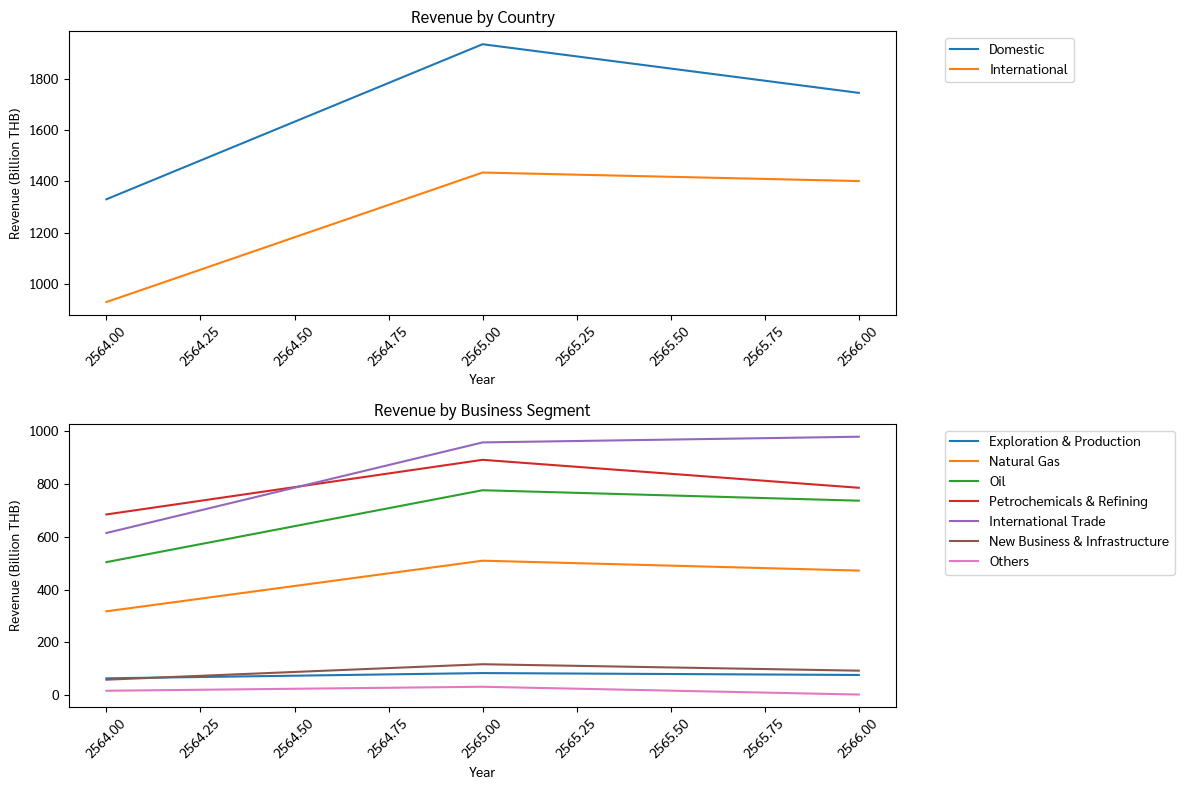

In [57]:
prompt = template.safe_substitute(
    SYMBOL=SYMBOL,
    bussiness_type=bussiness_type,
    income_domestic_foriegn=income_domestic_foriegn,
    revenue_by_business_group=revenue_by_business_group,
    other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    task="""Act as finanical analyst and analyse this data and write a Python code with the following sections:

1. Comment file header and show your thought how this data can support the investors
2. Use Matplotlib to create some visualisations to ease investors. Note:
 - You need to rotate X-axis ticks with 45 degree.
 - plot legends should be outside the chart
3. Use a string variable named "conclusion" to store your data analytics and conclusion in Markdown format.

You must give only the answer do not add prologue, prefix and suffix."""
)


python_code = get_gemini_completion(prompt)
exec(python_code.strip("`").lstrip("python").strip())

In [59]:
Markdown(conclusion)


## Data Analysis and Conclusion:

**Revenue Trends:**

- **PTT has shown a strong growth in revenue over the past three years.** 
  - Total revenue increased from 2,258.82 Billion THB in 2564 to 3,367.20 Billion THB in 2565.
  - However, revenue slightly declined to 3,144.55 Billion THB in 2566.
- **International operations are a significant contributor to PTT's revenue.**
  - International revenue consistently accounts for over 40% of total revenue.
  - This highlights the company's global reach and exposure to international markets.

**Key Revenue Drivers:**

- **The Petrochemicals & Refining segment is a major revenue driver.**
  - This segment consistently generates over 20% of total revenue.
  - Growth in this segment is crucial for PTT's overall revenue performance.
- **The International Trade segment also plays a significant role.**
  - It has contributed over 20% to total revenue in recent years.
  - This highlights the importance of global trade for PTT's business.

**Other Income Sources:**

- **Other income sources, particularly profit sharing, contribute to PTT's earnings.**
  - While these sources are relatively smaller, they add to overall profitability.

**Conclusion:**

- PTT is a diversified energy company with a strong presence in both domestic and international markets.
- The company's revenue growth is driven by various segments, with Petrochemicals & Refining and International Trade being key drivers.
- The increasing contribution of international operations suggests a focus on global expansion.
- Investors should consider the company's diversification, global reach, and revenue growth potential when making investment decisions.
